In [141]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import ElasticNet, LinearRegression, Lasso
import lightgbm as lgb
import xgboost as xgb
import joblib
import warnings
from statsmodels.stats.outliers_influence import variance_inflation_factor
import os
from datetime import datetime

# Suppress warnings
warnings.filterwarnings('ignore')

# Create directories for outputs
for directory in ['models', 'results']:
    if not os.path.exists(directory):
        os.makedirs(directory)

print("Current Date and Time:", datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S"))
print("Libraries imported and directories created!")

Current Date and Time: 2025-05-09 16:44:21
Libraries imported and directories created!


#### Dataset Overview and Summary of dataset

In [142]:
# Define file path for the dataset
input_csv_path = r"C:\ML Projects\DS-Intern-Assignment-Faheem-Khan\data\data.csv"


# Load the dataset
def load_data(file_path):
    """Load the dataset and convert data types."""
    # Load the dataset
    df = pd.read_csv(file_path)
    
    # Convert data types
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    for col in df.select_dtypes(include=['object']).columns:
        if col != 'timestamp':
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Sort by timestamp
    df = df.sort_values('timestamp').reset_index(drop=True)
    
    print(f"Loaded dataset with shape: {df.shape}")
    return df

# Load dataset
df = load_data(input_csv_path)

# Display the first few rows
print("\nFirst 5 rows of the dataset:")
print(df.head())

# Check data types
print("\nData types after conversion:")
print(df.dtypes)

Loaded dataset with shape: (16857, 29)

First 5 rows of the dataset:
            timestamp  equipment_energy_consumption  lighting_energy  \
0 2016-01-11 17:00:00                          60.0       -77.787786   
1 2016-01-11 17:10:00                          60.0        30.000000   
2 2016-01-11 17:20:00                          50.0        30.000000   
3 2016-01-11 17:30:00                          50.0        40.000000   
4 2016-01-11 17:40:00                          60.0        40.000000   

   zone1_temperature  zone1_humidity  zone2_temperature  zone2_humidity  \
0          33.746609       47.596667               19.2       44.790000   
1          19.890000       46.693333               19.2       44.722500   
2          19.890000       46.300000               19.2       44.626667   
3          33.746609       46.066667               19.2       44.590000   
4          19.890000       46.333333               19.2       44.530000   

   zone3_temperature  zone3_humidity  zone4_tem


Basic statistics:
                           timestamp  equipment_energy_consumption  \
count                          16857                  15945.000000   
mean   2016-03-10 02:16:38.647446272                     95.810413   
min              2016-01-11 17:00:00                  -1139.985693   
25%              2016-02-09 21:20:00                     50.000000   
50%              2016-03-10 00:10:00                     60.000000   
75%              2016-04-08 03:40:00                    100.000000   
max              2016-12-01 15:50:00                   1139.985693   
std                              NaN                    182.753554   

       lighting_energy  zone1_temperature  zone1_humidity  zone2_temperature  \
count     15993.000000       15908.000000    15969.000000       15934.000000   
mean          3.938101          21.249414       39.046066          19.793113   
min         -86.002966           8.726818      -46.660000           2.988199   
25%           0.000000        

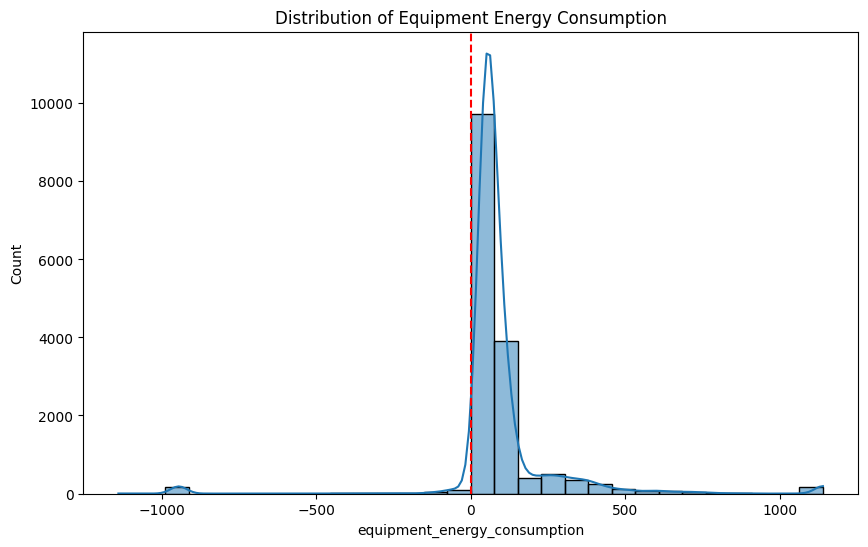

In [143]:
# Basic statistics of the dataset
print("\nBasic statistics:")
print(df.describe())

# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing values per column:")
print(missing_values)
print(f"Total missing values: {missing_values.sum()}")

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"\nDuplicate rows: {duplicates}")

# Analyze the target variable
def analyze_target_variable(df):
    """Analyze the target variable distribution."""
    target = 'equipment_energy_consumption'
    
    print("\n=== Target Variable Analysis ===")
    print(f"Unique values in {target}: {df[target].nunique()}")
    print(f"Min: {df[target].min()}, Max: {df[target].max()}")
    print("Most common values:")
    print(df[target].value_counts().head(10))
    
    # Check for negative values
    negative_count = (df[target] < 0).sum()
    print(f"\nNegative energy consumption values: {negative_count} ({negative_count/len(df)*100:.2f}% of data)")
    
    # Plot histogram of target variable
    plt.figure(figsize=(10, 6))
    sns.histplot(df[target], bins=30, kde=True)
    plt.title('Distribution of Equipment Energy Consumption')
    plt.axvline(x=0, color='red', linestyle='--')
    plt.savefig('results/target_distribution.png')
    plt.show()

# Run target analysis
analyze_target_variable(df)

### Correlation analysis 


=== Feature Relationships with Target ===
Top 10 correlations with energy consumption:
equipment_energy_consumption    1.000000
lighting_energy                 0.057007
zone2_temperature               0.042058
zone3_temperature               0.038033
outdoor_temperature             0.033223
zone6_temperature               0.032136
zone1_humidity                  0.026997
zone8_temperature               0.019716
zone1_temperature               0.018402
zone4_temperature               0.017128
wind_speed                      0.011566
Name: equipment_energy_consumption, dtype: float64

Bottom 5 correlations with energy consumption:
random_variable1   -0.016155
zone6_humidity     -0.019381
zone9_humidity     -0.022693
zone8_humidity     -0.023995
outdoor_humidity   -0.039493
Name: equipment_energy_consumption, dtype: float64

=== Random Variables Analysis ===
Correlation of random_variable1 with target: -0.0162
Correlation of random_variable2 with target: -0.0114


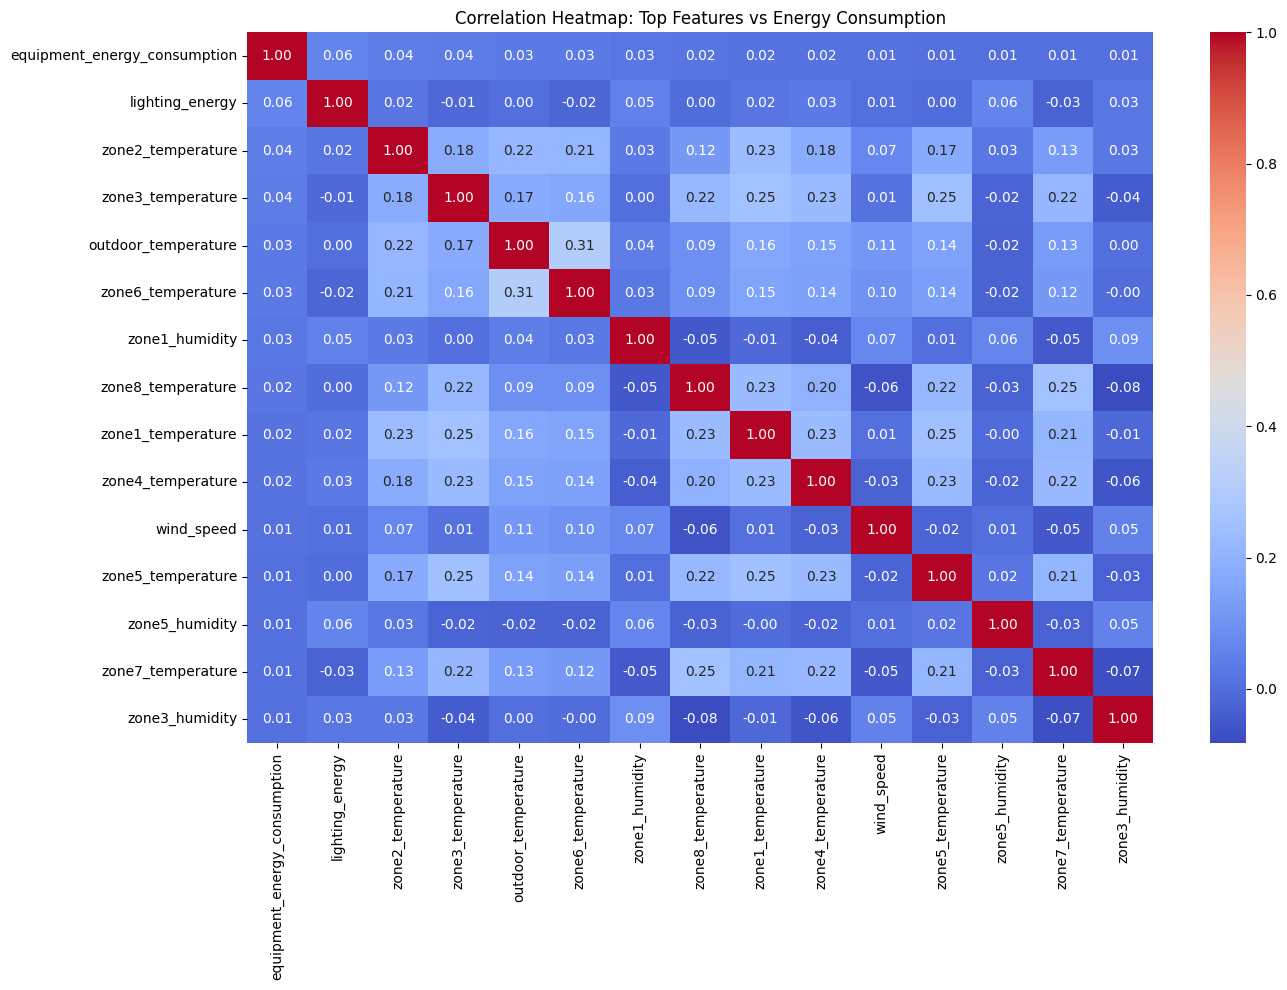

In [144]:
# Analyze correlations with target variable
def analyze_correlations(df):
    """Analyze correlations between features and target variable."""
    target = 'equipment_energy_consumption'
    correlations = df.corr()[target].sort_values(ascending=False)
    
    print("\n=== Feature Relationships with Target ===")
    print("Top 10 correlations with energy consumption:")
    print(correlations.head(11))  # 11 because it includes self-correlation
    
    print("\nBottom 5 correlations with energy consumption:")
    print(correlations.tail(5))
    
    # Check random variables specifically
    print("\n=== Random Variables Analysis ===")
    if 'random_variable1' in correlations:
        print(f"Correlation of random_variable1 with target: {correlations['random_variable1']:.4f}")
    if 'random_variable2' in correlations:
        print(f"Correlation of random_variable2 with target: {correlations['random_variable2']:.4f}")
    
    # Plot correlation heatmap for top features
    plt.figure(figsize=(14, 10))
    top_corr_features = correlations.head(15).index
    top_corr_df = df[top_corr_features].corr()
    sns.heatmap(top_corr_df, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap: Top Features vs Energy Consumption')
    plt.tight_layout()
    plt.savefig('results/correlation_heatmap.png')
    plt.show()
    
    return correlations

# Run correlation analysis
correlations = analyze_correlations(df)

## Correlation result 
=== Random Variables Analysis ===
Correlation of random_variable1 with target: -0.0162
Correlation of random_variable2 with target: -0.0114   we can drop the both random_variable

### EDA with Time pattern

#### Analyze time patterns

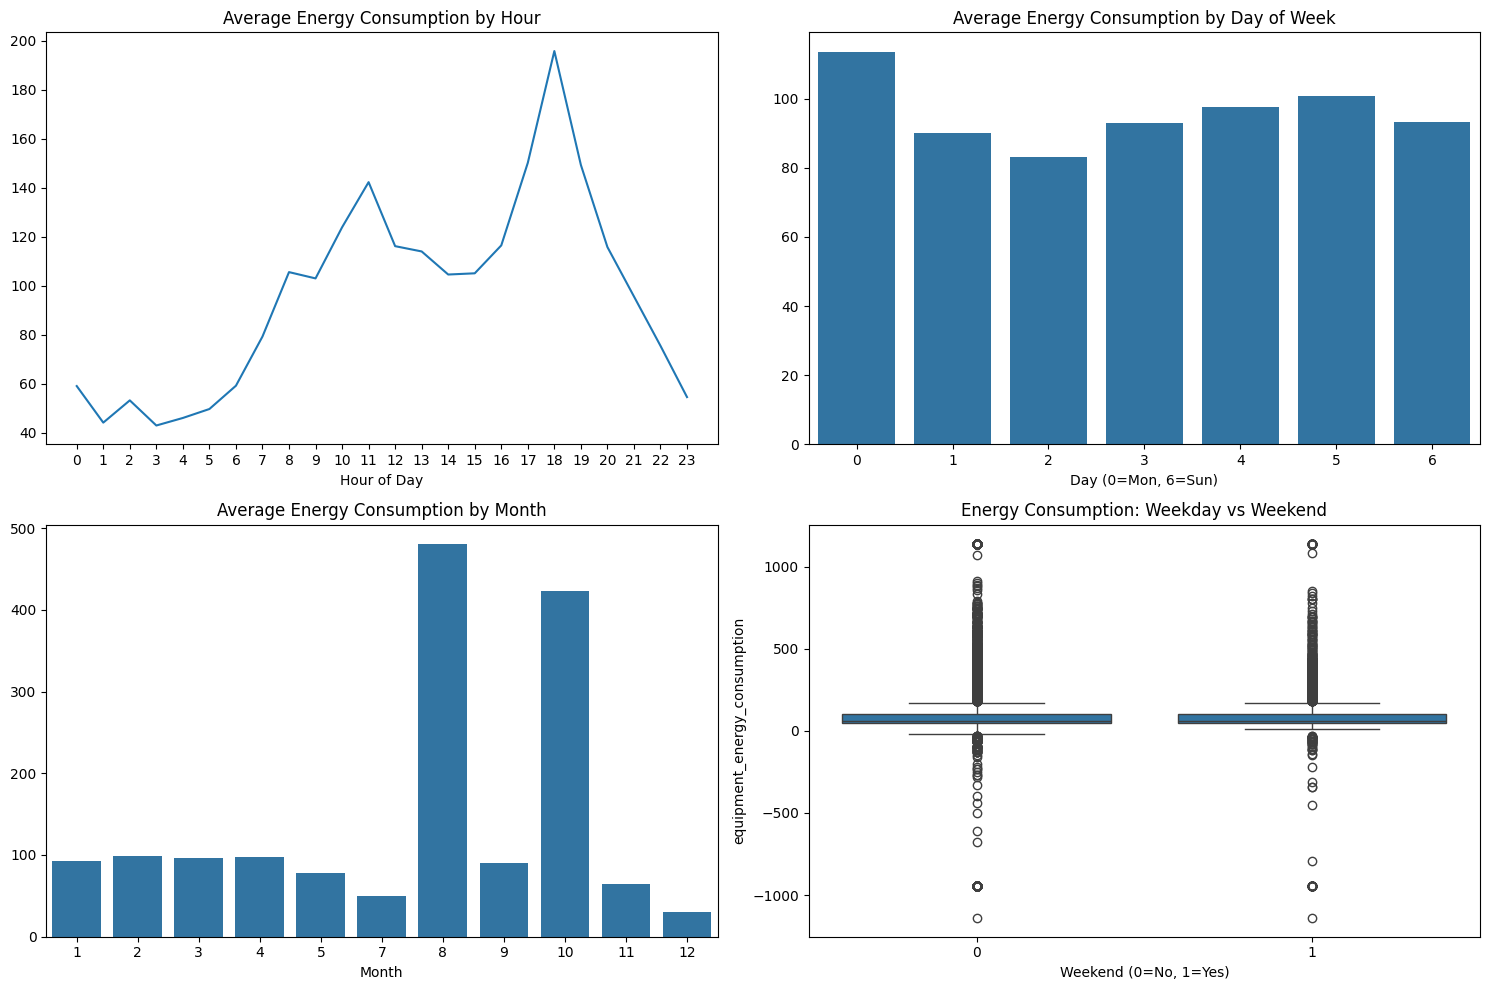

In [145]:

def analyze_time_patterns(df):
    """Analyze energy consumption patterns over time."""
    # Extract time components if not already present
    df = df.copy()
    df['hour'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['month'] = df['timestamp'].dt.month
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    # Plot energy patterns
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    hourly_avg = df.groupby('hour')['equipment_energy_consumption'].mean()
    sns.lineplot(x=hourly_avg.index, y=hourly_avg.values)
    plt.title('Average Energy Consumption by Hour')
    plt.xlabel('Hour of Day')
    plt.xticks(range(0, 24))
    
    plt.subplot(2, 2, 2)
    daily_avg = df.groupby('day_of_week')['equipment_energy_consumption'].mean()
    sns.barplot(x=daily_avg.index, y=daily_avg.values)
    plt.title('Average Energy Consumption by Day of Week')
    plt.xlabel('Day (0=Mon, 6=Sun)')
    
    plt.subplot(2, 2, 3)
    monthly_avg = df.groupby('month')['equipment_energy_consumption'].mean()
    sns.barplot(x=monthly_avg.index, y=monthly_avg.values)
    plt.title('Average Energy Consumption by Month')
    plt.xlabel('Month')
    
    plt.subplot(2, 2, 4)
    sns.boxplot(x='is_weekend', y='equipment_energy_consumption', data=df)
    plt.title('Energy Consumption: Weekday vs Weekend')
    plt.xlabel('Weekend (0=No, 1=Yes)')
    
    plt.tight_layout()
    plt.savefig('results/energy_patterns.png')
    plt.show()
    
    return df

# Analyze time patterns
df_with_time = analyze_time_patterns(df)

#### Data Cleaning


=== Handling Negative Energy Consumption ===
Statistics Before Correction:
count    15945.000000
mean        95.810413
std        182.753554
min      -1139.985693
25%         50.000000
50%         60.000000
75%        100.000000
max       1139.985693
Name: equipment_energy_consumption, dtype: float64
Negative values: 314 (1.86% of data)

Statistics After Correction:
count    15945.000000
mean       107.627948
std        147.312773
min         10.000000
25%         50.000000
50%         60.000000
75%        100.000000
max       1139.985693
Name: equipment_energy_consumption, dtype: float64


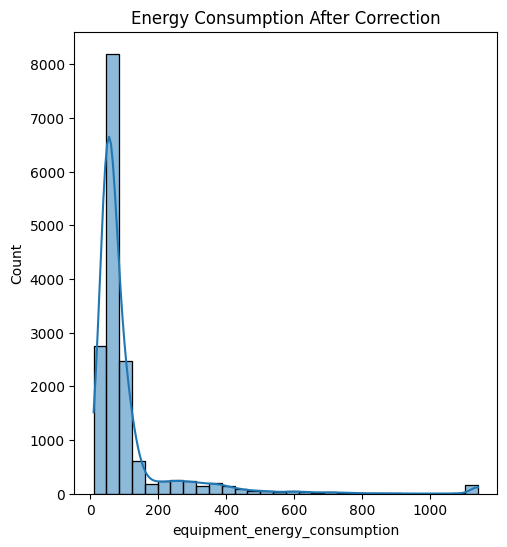

In [146]:
# Fix negative energy consumption values
def fix_energy_consumption(df):
    """Fix negative energy consumption values."""
    print("\n=== Handling Negative Energy Consumption ===")
    
    # Get original statistics
    print("Statistics Before Correction:")
    print(df['equipment_energy_consumption'].describe())
    
    # Count negative values
    negative_count = (df['equipment_energy_consumption'] < 0).sum()
    print(f"Negative values: {negative_count} ({negative_count/len(df)*100:.2f}% of data)")
    
    # Create copy to avoid modifying original
    df = df.copy()
    
    # Replace negative values with median of positive values
    positive_median = df[df['equipment_energy_consumption'] > 0]['equipment_energy_consumption'].median()
    df.loc[df['equipment_energy_consumption'] < 0, 'equipment_energy_consumption'] = positive_median
    
    # Get new statistics
    print("\nStatistics After Correction:")
    print(df['equipment_energy_consumption'].describe())
    
    # Plot before and after distribution
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(df['equipment_energy_consumption'], bins=30, kde=True)
    plt.title('Energy Consumption After Correction')
    plt.savefig('results/energy_corrected.png')
    plt.show()
    
    return df

# Fix negative energy values
df = fix_energy_consumption(df)

#### Handle missing values

In [147]:
# Handle missing values
def handle_missing_values(df):
    """Handle missing values in the dataset."""
    print("\n=== Handling Missing Values ===")
    
    df = df.copy()  # Create copy to avoid modifying original
    initial_missing = df.isnull().sum().sum()
    print(f"Initial missing values: {initial_missing}")
    
    # For target variable, drop rows with missing values
    df = df.dropna(subset=['equipment_energy_consumption'])
    
    # For sensor data, use time-based interpolation
    df_with_time_index = df.set_index('timestamp')
    
    # Sensor columns
    sensor_cols = [col for col in df_with_time_index.columns if any(x in col for x in ['temperature', 'humidity', 'pressure'])]
    for col in sensor_cols:
        df_with_time_index[col] = df_with_time_index[col].interpolate(method='time')
    
    # Reset index to get timestamp back as a column
    df = df_with_time_index.reset_index()
    
    # For remaining columns, use median imputation
    remaining_cols = [col for col in df.columns if col not in sensor_cols and col != 'timestamp' and col != 'equipment_energy_consumption']
    for col in remaining_cols:
        df[col] = df[col].fillna(df[col].median())
        
    # Fill any remaining NA values in target
    positive_median = df[df['equipment_energy_consumption'] > 0]['equipment_energy_consumption'].median()
    df['equipment_energy_consumption'] = df['equipment_energy_consumption'].fillna(positive_median)
    
    # drop missing values in zone3_humidity zone6_temperature   
    df = df.dropna(subset=['zone3_humidity', 'zone6_temperature'])
    
    
    # drop duplicate all raws
    df = df.drop_duplicates()
    
    final_missing = df.isnull().sum().sum()
    print(f"Remaining missing values: {final_missing}")
    
    return df

# Handle missing values
df = handle_missing_values(df)




=== Handling Missing Values ===
Initial missing values: 23465
Remaining missing values: 0


#### Fix implausible values

In [148]:
# Fix implausible values
def fix_implausible_values(df):
    """Fix implausible values in the dataset."""
    print("\n=== Handling Implausible Values ===")
    
    df = df.copy()  # Create copy to avoid modifying original
    
    # Fix temperature values
    temp_cols = [col for col in df.columns if 'temperature' in col]
    for col in temp_cols:
        if 'outdoor' not in col:  # Indoor temperatures shouldn't be negative
            neg_count = (df[col] < 0).sum()
            if neg_count > 0:
                print(f"Fixing {neg_count} negative values in {col}")
                df.loc[df[col] < 0, col] = df[df[col] > 0][col].median()
    
    # Fix humidity values (should be 0-100%)
    humidity_cols = [col for col in df.columns if 'humidity' in col]
    for col in humidity_cols:
        neg_count = (df[col] < 0).sum()
        high_count = (df[col] > 100).sum()
        if neg_count > 0 or high_count > 0:
            print(f"Fixing {neg_count} negative and {high_count} >100% values in {col}")
            df.loc[df[col] < 0, col] = df[df[col] >= 0 & (df[col] <= 100)][col].median()
            df.loc[df[col] > 100, col] = 100
    
    return df

# Fix implausible values
df = fix_implausible_values(df)


=== Handling Implausible Values ===
Fixing 1445 negative values in zone6_temperature
Fixing 153 negative and 0 >100% values in zone1_humidity
Fixing 139 negative and 0 >100% values in zone2_humidity
Fixing 182 negative and 0 >100% values in zone3_humidity
Fixing 334 negative and 0 >100% values in zone4_humidity
Fixing 299 negative and 176 >100% values in zone5_humidity
Fixing 304 negative and 179 >100% values in zone6_humidity
Fixing 337 negative and 0 >100% values in zone7_humidity
Fixing 316 negative and 0 >100% values in zone8_humidity
Fixing 181 negative and 0 >100% values in zone9_humidity
Fixing 295 negative and 142 >100% values in outdoor_humidity


#### Handling Outliers

In [149]:
# Handle outliers
def handle_outliers(df):
    """Handle outliers in the dataset."""
    print("\n=== Handling Outliers ===")
    
    df = df.copy()  # Create copy to avoid modifying original
    
    # Don't modify the target variable
    cols_to_check = df.select_dtypes(include=['float64', 'int64']).columns
    cols_to_check = [col for col in cols_to_check if col != 'equipment_energy_consumption']
    
    # Use a conservative approach (5 std devs from mean)
    for col in cols_to_check:
        mean_val = df[col].mean()
        std_val = df[col].std()
        
        lower_bound = mean_val - 5 * std_val
        upper_bound = mean_val + 5 * std_val
        
        outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        if outliers > 0:
            print(f"Capping {outliers} extreme outliers in {col}")
            df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    
    return df

# Handle outliers
df = handle_outliers(df)


=== Handling Outliers ===
Capping 335 extreme outliers in lighting_energy
Capping 303 extreme outliers in zone1_temperature
Capping 310 extreme outliers in zone1_humidity
Capping 313 extreme outliers in zone2_temperature
Capping 359 extreme outliers in zone2_humidity
Capping 297 extreme outliers in zone3_temperature
Capping 280 extreme outliers in zone3_humidity
Capping 335 extreme outliers in zone4_temperature
Capping 173 extreme outliers in zone4_humidity
Capping 337 extreme outliers in zone5_temperature
Capping 169 extreme outliers in zone6_temperature
Capping 343 extreme outliers in zone7_temperature
Capping 145 extreme outliers in zone7_humidity
Capping 314 extreme outliers in zone8_temperature
Capping 170 extreme outliers in zone8_humidity
Capping 318 extreme outliers in zone9_temperature
Capping 313 extreme outliers in zone9_humidity
Capping 312 extreme outliers in outdoor_temperature
Capping 324 extreme outliers in atmospheric_pressure
Capping 13 extreme outliers in outdoor_hu

In [150]:
# Final data quality check
print("\n=== Final Data Quality Check ===")
print(f"Shape after preprocessing: {df.shape}")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Duplicate rows: {df.duplicated().sum()}")

# Sort by timestamp for time series analysis
df = df.sort_values('timestamp').reset_index(drop=True)

# Display cleaned data
print("\nFirst 5 rows of cleaned data:")
print(df.head())


=== Final Data Quality Check ===
Shape after preprocessing: (15878, 29)
Missing values: 0
Duplicate rows: 0

First 5 rows of cleaned data:
            timestamp  equipment_energy_consumption  lighting_energy  \
0 2016-01-11 17:10:00                          60.0             30.0   
1 2016-01-11 17:20:00                          50.0             30.0   
2 2016-01-11 17:30:00                          50.0             40.0   
3 2016-01-11 17:40:00                          60.0             40.0   
4 2016-01-11 17:50:00                          50.0             40.0   

   zone1_temperature  zone1_humidity  zone2_temperature  zone2_humidity  \
0          19.890000       46.693333               19.2       44.722500   
1          19.890000       46.300000               19.2       44.626667   
2          31.966904       46.066667               19.2       44.590000   
3          19.890000       46.333333               19.2       44.530000   
4          19.890000       46.026667               1

#### Feature Engineering

##### Create Time Features

In [151]:
# Create time features
def create_time_features(df):
    """Create time-based features from timestamp."""
    df = df.copy()
    
    # Extract time components
    df['hour'] = df['timestamp'].dt.hour
    df['day'] = df['timestamp'].dt.day
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['month'] = df['timestamp'].dt.month
    df['quarter'] = df['timestamp'].dt.quarter
    df['year'] = df['timestamp'].dt.year
    
    # Cyclical encoding of time features
    df['hour_sin'] = np.sin(df['hour'] * (2 * np.pi / 24))
    df['hour_cos'] = np.cos(df['hour'] * (2 * np.pi / 24))
    df['day_of_week_sin'] = np.sin(df['day_of_week'] * (2 * np.pi / 7))
    df['day_of_week_cos'] = np.cos(df['day_of_week'] * (2 * np.pi / 7))
    df['month_sin'] = np.sin((df['month'] - 1) * (2 * np.pi / 12))
    df['month_cos'] = np.cos((df['month'] - 1) * (2 * np.pi / 12))
    df['day_sin'] = np.sin((df['day'] - 1) * (2 * np.pi / 31))
    df['day_cos'] = np.cos((df['day'] - 1) * (2 * np.pi / 31))
    
    # Time categorial features
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['is_working_hours'] = ((df['hour'] >= 8) & (df['hour'] <= 18) & ~df['day_of_week'].isin([5, 6])).astype(int)
    df['is_night'] = ((df['hour'] < 6) | (df['hour'] >= 22)).astype(int)
    
    # Special day parts
    df['morning'] = ((df['hour'] >= 5) & (df['hour'] < 12)).astype(int)
    df['afternoon'] = ((df['hour'] >= 12) & (df['hour'] < 18)).astype(int)
    df['evening'] = ((df['hour'] >= 18) & (df['hour'] < 22)).astype(int)
    
    return df

# Create time features
df = create_time_features(df)
print(f"Shape after adding time features: {df.shape}")

Shape after adding time features: (15878, 49)


##### Create lag features

In [152]:
# Create lag features
def create_lag_features(df):
    """Create lag features for time series modeling."""
    df = df.copy()
    
    # Ensure dataframe is sorted by timestamp
    df = df.sort_values('timestamp')
    
    # Create lag features
    lags = [1, 2, 3, 6, 12, 24]  # 1, 2, 3, 6, 12, and 24 hours ago
    for lag in lags:
        df[f'energy_lag_{lag}h'] = df['equipment_energy_consumption'].shift(lag)
    
    # Create rolling window features
    windows = [3, 6, 12, 24]
    for window in windows:
        # Rolling mean (captures trend)
        df[f'energy_rolling_mean_{window}h'] = df['equipment_energy_consumption'].rolling(
            window=window, min_periods=1).mean()
        
        # Rolling std (captures volatility)
        df[f'energy_rolling_std_{window}h'] = df['equipment_energy_consumption'].rolling(
            window=window, min_periods=1).std()
        
        # Rolling min and max
        df[f'energy_rolling_min_{window}h'] = df['equipment_energy_consumption'].rolling(
            window=window, min_periods=1).min()
        df[f'energy_rolling_max_{window}h'] = df['equipment_energy_consumption'].rolling(
            window=window, min_periods=1).max()
        
        # Rolling range (max-min)
        df[f'energy_rolling_range_{window}h'] = (
            df[f'energy_rolling_max_{window}h'] - df[f'energy_rolling_min_{window}h']
        )
    
    return df

# Create lag features
df = create_lag_features(df)
print(f"Shape after adding lag features: {df.shape}")

Shape after adding lag features: (15878, 75)


##### Create zone features

In [153]:
# Create zone features
def create_zone_features(df):
    """Create features related to factory zones."""
    df = df.copy()
    
    # Zone temperature statistics
    temp_cols = [col for col in df.columns if 'temperature' in col and 'outdoor' not in col]
    if temp_cols:
        df['avg_zone_temp'] = df[temp_cols].mean(axis=1)
        df['min_zone_temp'] = df[temp_cols].min(axis=1)
        df['max_zone_temp'] = df[temp_cols].max(axis=1)
        df['zone_temp_range'] = df['max_zone_temp'] - df['min_zone_temp']
    
    # Zone humidity statistics
    humidity_cols = [col for col in df.columns if 'humidity' in col and 'outdoor' not in col]
    if humidity_cols:
        df['avg_zone_humidity'] = df[humidity_cols].mean(axis=1)
        df['min_zone_humidity'] = df[humidity_cols].min(axis=1)
        df['max_zone_humidity'] = df[humidity_cols].max(axis=1)
        df['zone_humidity_range'] = df['max_zone_humidity'] - df['min_zone_humidity']
    
    # Temperature-humidity interactions for each zone (heat index)
    for i in range(1, 10):
        temp_col = f'zone{i}_temperature'
        hum_col = f'zone{i}_humidity'
        
        if temp_col in df.columns and hum_col in df.columns:
            # Heat index approximation (temp-humidity interaction effect)
            df[f'zone{i}_heat_index'] = df[temp_col] - 0.55 * (1 - df[hum_col]/100) * (df[temp_col] - 14.5)
    
    return df

# Create zone features
df = create_zone_features(df)
print(f"Shape after adding zone features: {df.shape}")

Shape after adding zone features: (15878, 92)


##### Create weather features

In [154]:
# Create weather features
def create_weather_features(df):
    """Create weather-related features."""
    df = df.copy()
    
    # Indoor-outdoor temperature differential
    if 'outdoor_temperature' in df.columns and 'avg_zone_temp' in df.columns:
        df['indoor_outdoor_temp_diff'] = df['avg_zone_temp'] - df['outdoor_temperature']
        
        # Individual zone temperature differentials
        for i in range(1, 10):
            temp_col = f'zone{i}_temperature'
            if temp_col in df.columns:
                df[f'zone{i}_outdoor_temp_diff'] = df[temp_col] - df['outdoor_temperature']
    
    # Wind chill effect (approximation)
    if 'wind_speed' in df.columns and 'outdoor_temperature' in df.columns:
        df['wind_chill'] = df.apply(
            lambda x: x['outdoor_temperature'] - (x['wind_speed'] * 0.7) 
            if x['outdoor_temperature'] < 10 and x['wind_speed'] > 0 
            else x['outdoor_temperature'], 
            axis=1
        )
    
    # Differential features
    for col in ['avg_zone_temp', 'outdoor_temperature', 'atmospheric_pressure']:
        if col in df.columns:
            # Change from previous hour
            df[f'{col}_change_1h'] = df[col] - df[col].shift(1)
            
            # Rate of change (derivative)
            df[f'{col}_rate_of_change'] = df[f'{col}_change_1h'] / 1.0  # per hour
    
    return df

# Create weather features
df = create_weather_features(df)
print(f"Shape after adding weather features: {df.shape}")

Shape after adding weather features: (15878, 109)


##### Create weather features

In [155]:
# Create weather features
def create_weather_features(df):
    """Create weather-related features."""
    df = df.copy()
    
    # Indoor-outdoor temperature differential
    if 'outdoor_temperature' in df.columns and 'avg_zone_temp' in df.columns:
        df['indoor_outdoor_temp_diff'] = df['avg_zone_temp'] - df['outdoor_temperature']
        
        # Individual zone temperature differentials
        for i in range(1, 10):
            temp_col = f'zone{i}_temperature'
            if temp_col in df.columns:
                df[f'zone{i}_outdoor_temp_diff'] = df[temp_col] - df['outdoor_temperature']
    
    # Wind chill effect (approximation)
    if 'wind_speed' in df.columns and 'outdoor_temperature' in df.columns:
        df['wind_chill'] = df.apply(
            lambda x: x['outdoor_temperature'] - (x['wind_speed'] * 0.7) 
            if x['outdoor_temperature'] < 10 and x['wind_speed'] > 0 
            else x['outdoor_temperature'], 
            axis=1
        )
    
    # Differential features
    for col in ['avg_zone_temp', 'outdoor_temperature', 'atmospheric_pressure']:
        if col in df.columns:
            # Change from previous hour
            df[f'{col}_change_1h'] = df[col] - df[col].shift(1)
            
            # Rate of change (derivative)
            df[f'{col}_rate_of_change'] = df[f'{col}_change_1h'] / 1.0  # per hour
    
    return df

# Create weather features
df = create_weather_features(df)
print(f"Shape after adding weather features: {df.shape}")

Shape after adding weather features: (15878, 109)


##### Remove random variables and finalize feature engineering

In [156]:
# Remove random variables and finalize feature engineering
def finalize_features(df):
    """Finalize feature engineering and prepare for modeling."""
    df = df.copy()
    
    # Exclude random variables based on correlation analysis
    print("Excluding random variables due to very low correlation with target")
    df = df.drop(['random_variable1', 'random_variable2'], axis=1, errors='ignore')
    
    # Drop rows with NaN from lag features and reset index
    df = df.dropna().reset_index(drop=True)
    
    return df

# Finalize features
df = finalize_features(df)
print(f"Final dataset shape after feature engineering: {df.shape}")

Excluding random variables due to very low correlation with target
Final dataset shape after feature engineering: (15854, 107)


##### Calculate Variance Inflation Factor (VIF) for features

In [157]:
# Calculate Variance Inflation Factor (VIF) for features
def calculate_vif(X):
    """Calculate VIF for each feature."""
    # Add constant
    X_with_const = pd.DataFrame({"const": np.ones(len(X))}, index=X.index)
    X_with_const = pd.concat([X_with_const, X], axis=1)
    
    # Calculate VIF for each feature
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X_with_const.columns
    vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) 
                        for i in range(X_with_const.shape[1])]
    
    return vif_data.sort_values("VIF", ascending=False)

# Prepare data for VIF calculation
X_for_vif = df.drop(['timestamp'], axis=1, errors='ignore')

# Calculate VIF
print("=== Multicollinearity Analysis with VIF ===")
vif_results = calculate_vif(X_for_vif)
print("\nVariance Inflation Factor (VIF) for each feature:")
print(vif_results)

# Save VIF results
vif_results.to_csv("results/vif_analysis.csv", index=False)

=== Multicollinearity Analysis with VIF ===

Variance Inflation Factor (VIF) for each feature:
                         Feature       VIF
1   equipment_energy_consumption       inf
4                 zone1_humidity       inf
3              zone1_temperature       inf
7              zone3_temperature       inf
8                 zone3_humidity       inf
..                           ...       ...
52                energy_lag_24h  1.186555
2                lighting_energy  1.071387
25              visibility_index  1.024172
32                          year  0.000000
0                          const  0.000000

[107 rows x 2 columns]


##### Handle multicollinearity based on VIF analysis

In [158]:
# Handle multicollinearity based on VIF analysis
def reduce_multicollinearity(df, vif_results, vif_threshold=100):
    """
    Reduce multicollinearity by selecting one feature from each highly collinear group.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe
    vif_results : pandas.DataFrame
        DataFrame with VIF scores for each feature
    vif_threshold : float
        Threshold for VIF scores to consider as high multicollinearity
        
    Returns:
    --------
    pandas.DataFrame
        Dataframe with reduced multicollinearity
    """
    print("\n=== Reducing Multicollinearity Based on VIF Analysis ===")
    
    # Create a copy of the dataframe
    df_reduced = df.copy()
    
    # Keep the target variable
    target = 'equipment_energy_consumption'
    
    # Create groups of collinear features based on VIF analysis
    # These groupings are based on the domain knowledge and feature names
    
    # Group 1: Zone temperature features (keep one per zone)
    zone_temp_features = [f'zone{i}_temperature' for i in range(1, 10)]
    
    # Group 2: Zone humidity features (keep one)
    zone_humidity_features = [f'zone{i}_humidity' for i in range(1, 10)]
    
    # Group 3: Zone heat index features (have lower VIF, keep them)
    zone_heat_index_features = [f'zone{i}_heat_index' for i in range(1, 10)]
    
    # Group 4: Lag features (keep only the most important ones)
    lag_features = ['energy_lag_1h', 'energy_lag_2h']  # Keep these two, drop others
    
    # Group 5: Rolling statistics (keep mean, drop others)
    rolling_mean_features = ['energy_rolling_mean_3h']  # Keep this one
    rolling_features_to_drop = [
        'energy_rolling_max_3h', 'energy_rolling_min_3h', 'energy_rolling_range_3h',
        'energy_rolling_max_6h', 'energy_rolling_min_6h', 'energy_rolling_range_6h',
        'energy_rolling_max_12h', 'energy_rolling_min_12h', 'energy_rolling_range_12h',
        'energy_rolling_max_24h', 'energy_rolling_min_24h', 'energy_rolling_range_24h'
    ]
    
    # Group 6: Temperature difference features (keep indoor_outdoor_temp_diff, drop zone-specific diffs)
    temp_diff_features_to_drop = [f'zone{i}_outdoor_temp_diff' for i in range(1, 10)]
    
    # Group 7: Rate of change features (all have high VIF, drop them)
    rate_change_features = [
        'atmospheric_pressure_rate_of_change', 'outdoor_temperature_rate_of_change',
        'avg_zone_temp_rate_of_change'
    ]
    
    # Group 8: Change features (keep simpler ones)
    change_features_to_drop = [
        'atmospheric_pressure_change_1h', 'outdoor_temperature_change_1h',
        'avg_zone_temp_change_1h'
    ]
    
    # Group 9: Zone statistics (some are duplicative)
    zone_stats_to_drop = [
        'max_zone_temp', 'min_zone_temp', 'zone_temp_range',
        'max_zone_humidity', 'min_zone_humidity', 'zone_humidity_range'
    ]
    
    # Combine all features to drop
    features_to_drop = (
        rolling_features_to_drop + 
        temp_diff_features_to_drop + 
        rate_change_features + 
        change_features_to_drop + 
        zone_stats_to_drop
    )
    
    # Features to keep (make sure they exist in the dataframe)
    features_to_keep = (
        zone_temp_features + 
        zone_heat_index_features + 
        ['avg_zone_temp', 'avg_zone_humidity', 'outdoor_temperature'] + 
        lag_features +
        rolling_mean_features +
        ['indoor_outdoor_temp_diff'] +
        ['hour_sin', 'hour_cos', 'is_working_hours']
    )
    
    # Check if features exist in the dataframe
    features_to_keep = [f for f in features_to_keep if f in df.columns]
    features_to_drop = [f for f in features_to_drop if f in df.columns]
    
    # Drop features with high multicollinearity
    df_reduced = df.drop(features_to_drop, axis=1, errors='ignore')
    
    # Make sure to keep timestamp and target
    if 'timestamp' not in features_to_keep and 'timestamp' in df.columns:
        features_to_keep.append('timestamp')
    if target not in features_to_keep and target in df.columns:
        features_to_keep.append(target)
    
    # For debugging, print the number of features kept
    print(f"Reduced features from {df.shape[1]} to {len(features_to_keep)} potential features")
    
    return df_reduced

# Use the function to reduce multicollinearity
df_reduced = reduce_multicollinearity(df, vif_results)

# Display remaining columns
print("\nRemaining columns after multicollinearity reduction:")
print(df_reduced.columns.tolist())


=== Reducing Multicollinearity Based on VIF Analysis ===
Reduced features from 107 to 30 potential features

Remaining columns after multicollinearity reduction:
['timestamp', 'equipment_energy_consumption', 'lighting_energy', 'zone1_temperature', 'zone1_humidity', 'zone2_temperature', 'zone2_humidity', 'zone3_temperature', 'zone3_humidity', 'zone4_temperature', 'zone4_humidity', 'zone5_temperature', 'zone5_humidity', 'zone6_temperature', 'zone6_humidity', 'zone7_temperature', 'zone7_humidity', 'zone8_temperature', 'zone8_humidity', 'zone9_temperature', 'zone9_humidity', 'outdoor_temperature', 'atmospheric_pressure', 'outdoor_humidity', 'wind_speed', 'visibility_index', 'dew_point', 'hour', 'day', 'day_of_week', 'month', 'quarter', 'year', 'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'is_weekend', 'is_working_hours', 'is_night', 'morning', 'afternoon', 'evening', 'energy_lag_1h', 'energy_lag_2h', 'energy_lag_3h', 'energy

##### Prepare data for modeling with reduced feature set

In [159]:
# Prepare data for modeling with reduced feature set
def prepare_model_data(df_reduced):
    """
    Prepare data for modeling by splitting into train and test sets.
    
    Parameters:
    -----------
    df_reduced : pandas.DataFrame
        Dataframe with reduced multicollinearity
        
    Returns:
    --------
    tuple
        X_train, X_test, X_train_scaled, X_test_scaled, y_train, y_test, scaler
    """
    print("\n=== Preparing Data for Time Series Modeling ===")
    
    # Sort by timestamp to maintain time series integrity
    if 'timestamp' in df_reduced.columns:
        df_reduced = df_reduced.sort_values('timestamp')
    
    # Separate features and target
    X = df_reduced.drop(['timestamp', 'equipment_energy_consumption'], axis=1, errors='ignore')
    y = df_reduced['equipment_energy_consumption']
    
    # Split into training and testing sets (80% train, 20% test)
    split_idx = int(len(df_reduced) * 0.8)
    X_train = X.iloc[:split_idx]
    X_test = X.iloc[split_idx:]
    y_train = y.iloc[:split_idx]
    y_test = y.iloc[split_idx:]
    
    print(f"Training set: {X_train.shape}")
    print(f"Test set: {X_test.shape}")
    
    # Scale features for models like ElasticNet
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
    
    return X_train, X_test, X_train_scaled, X_test_scaled, y_train, y_test, scaler

# Prepare data for modeling
X_train, X_test, X_train_scaled, X_test_scaled, y_train, y_test, scaler = prepare_model_data(df_reduced)


=== Preparing Data for Time Series Modeling ===
Training set: (12683, 72)
Test set: (3171, 72)


##### Feature selection based on Lasso regularization

In [160]:
# Feature selection based on Lasso regularization
def select_important_features(X_train, X_test, X_train_scaled, X_test_scaled, y_train, max_features=20):
    """
    Select important features using Lasso regularization.
    
    Parameters:
    -----------
    X_train : pandas.DataFrame
        Training features
    X_test : pandas.DataFrame
        Test features
    X_train_scaled : pandas.DataFrame
        Scaled training features
    X_test_scaled : pandas.DataFrame
        Scaled test features
    y_train : pandas.Series
        Training target
    max_features : int, optional
        Maximum number of features to select, by default 20
        
    Returns:
    --------
    tuple
        X_train_selected, X_test_selected, X_train_scaled_selected, X_test_scaled_selected, selected_features
    """
    print(f"\n=== Selecting Top {max_features} Important Features ===")
    
    # Use Lasso for feature selection
    lasso = Lasso(alpha=0.01, random_state=42)
    selector = SelectFromModel(
        lasso,
        max_features=max_features,
        threshold=-np.inf  # Ensure exactly max_features are selected
    )
    
    # Fit the selector on scaled data (important for Lasso)
    selector.fit(X_train_scaled, y_train)
    
    # Get selected feature mask and names
    selected_mask = selector.get_support()
    selected_features = X_train.columns[selected_mask].tolist()
    
    # Create reduced feature datasets
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]
    X_train_scaled_selected = X_train_scaled[selected_features]
    X_test_scaled_selected = X_test_scaled[selected_features]
    
    print(f"Selected {len(selected_features)} features:")
    for feature in selected_features:
        print(f"- {feature}")
    
    return X_train_selected, X_test_selected, X_train_scaled_selected, X_test_scaled_selected, selected_features

# Select important features
X_train_selected, X_test_selected, X_train_scaled_selected, X_test_scaled_selected, selected_features = select_important_features(
    X_train, X_test, X_train_scaled, X_test_scaled, y_train, max_features=15
)


=== Selecting Top 15 Important Features ===
Selected 15 features:
- zone1_temperature
- zone2_temperature
- zone3_temperature
- zone4_temperature
- zone5_temperature
- zone6_temperature
- zone7_temperature
- energy_lag_1h
- energy_lag_2h
- energy_rolling_mean_3h
- avg_zone_temp
- avg_zone_humidity
- zone1_heat_index
- zone2_heat_index
- zone3_heat_index


##### Train ElasticNet model on selected features

In [161]:
# Train ElasticNet model on selected features
def train_elasticnet_model(X_train_scaled_selected, X_test_scaled_selected, y_train, y_test):
    """
    Train ElasticNet model on selected features.
    
    Parameters:
    -----------
    X_train_scaled_selected : pandas.DataFrame
        Selected scaled training features
    X_test_scaled_selected : pandas.DataFrame
        Selected scaled test features
    y_train : pandas.Series
        Training target
    y_test : pandas.Series
        Test target
        
    Returns:
    --------
    tuple
        model, y_pred, r2, rmse, mae
    """
    print("\n=== Training ElasticNet Model on Selected Features ===")
    
    # Create and train ElasticNet model
    model = ElasticNet(
        alpha=0.01,
        l1_ratio=0.5,
        max_iter=10000,
        random_state=42
    )
    
    model.fit(X_train_scaled_selected, y_train)
    y_pred = model.predict(X_test_scaled_selected)
    
    # Calculate performance metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    print(f"\nElasticNet Model Performance:")
    print(f"R²: {r2:.4f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    
    return model, y_pred, r2, rmse, mae

# Train ElasticNet model
elasticnet_model, elasticnet_pred, elasticnet_r2, elasticnet_rmse, elasticnet_mae = train_elasticnet_model(
    X_train_scaled_selected, X_test_scaled_selected, y_train, y_test
)


=== Training ElasticNet Model on Selected Features ===

ElasticNet Model Performance:
R²: 0.9985
RMSE: 5.11
MAE: 2.12


In [162]:
# Train LightGBM model on selected features
def train_lightgbm_model(X_train_selected, X_test_selected, y_train, y_test):
    """
    Train LightGBM model on selected features.
    
    Parameters:
    -----------
    X_train_selected : pandas.DataFrame
        Selected training features
    X_test_selected : pandas.DataFrame
        Selected test features
    y_train : pandas.Series
        Training target
    y_test : pandas.Series
        Test target
        
    Returns:
    --------
    tuple
        model, y_pred, r2, rmse, mae
    """
    print("\n=== Training LightGBM Model on Selected Features ===")
    
    # Create and train LightGBM model
    model = lgb.LGBMRegressor(
        n_estimators=500,
        learning_rate=0.01,
        num_leaves=31,
        max_depth=10,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=0.1,
        random_state=42
    )
    
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    
    # Calculate performance metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    print(f"\nLightGBM Model Performance:")
    print(f"R²: {r2:.4f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    
    return model, y_pred, r2, rmse, mae

# Train LightGBM model
lightgbm_model, lightgbm_pred, lightgbm_r2, lightgbm_rmse, lightgbm_mae = train_lightgbm_model(
    X_train_selected, X_test_selected, y_train, y_test
)


=== Training LightGBM Model on Selected Features ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3414
[LightGBM] [Info] Number of data points in the train set: 12683, number of used features: 15
[LightGBM] [Info] Start training from score 108.713871

LightGBM Model Performance:
R²: 0.9711
RMSE: 22.54
MAE: 12.02


In [163]:
# Train XGBoost model on selected features
def train_xgboost_model(X_train_selected, X_test_selected, y_train, y_test):
    """
    Train XGBoost model on selected features.
    
    Parameters:
    -----------
    X_train_selected : pandas.DataFrame
        Selected training features
    X_test_selected : pandas.DataFrame
        Selected test features
    y_train : pandas.Series
        Training target
    y_test : pandas.Series
        Test target
        
    Returns:
    --------
    tuple
        model, y_pred, r2, rmse, mae
    """
    print("\n=== Training XGBoost Model on Selected Features ===")
    
    # Create and train XGBoost model
    model = xgb.XGBRegressor(
        n_estimators=500,
        learning_rate=0.01,
        max_depth=10,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=0.1,
        random_state=42
    )
    
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    
    # Calculate performance metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    print(f"\nXGBoost Model Performance:")
    print(f"R²: {r2:.4f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    
    return model, y_pred, r2, rmse, mae

# Train XGBoost model
xgboost_model, xgboost_pred, xgboost_r2, xgboost_rmse, xgboost_mae = train_xgboost_model(
    X_train_selected, X_test_selected, y_train, y_test
)


=== Training XGBoost Model on Selected Features ===

XGBoost Model Performance:
R²: 0.9427
RMSE: 31.71
MAE: 13.44



=== Model Comparison ===
        Model        R²       RMSE        MAE
0  ElasticNet  0.998510   5.113136   2.122397
1    LightGBM  0.971062  22.535764  12.015101
2     XGBoost  0.942697  31.712197  13.444195

Best model: ElasticNet with R² = 0.9985


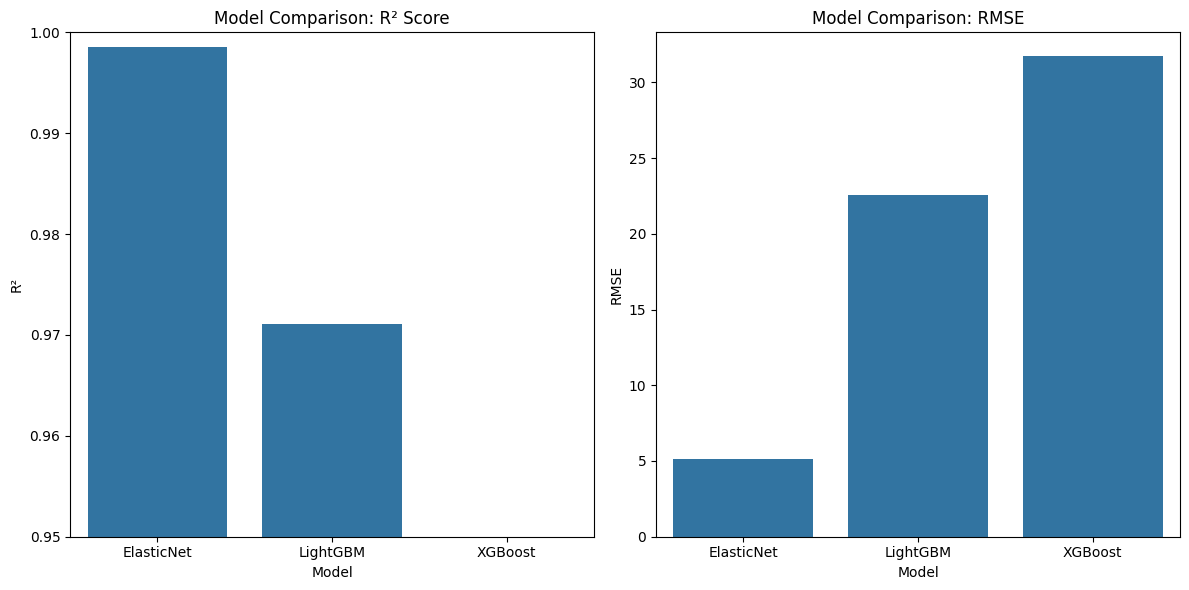

In [164]:
# Compare models and select the best one
def compare_models(models_dict):
    """
    Compare models and select the best one.
    
    Parameters:
    -----------
    models_dict : dict
        Dictionary with model results
        
    Returns:
    --------
    tuple
        best_model_name, best_model, best_pred, best_r2
    """
    print("\n=== Model Comparison ===")
    
    # Create comparison dataframe
    comparison = pd.DataFrame({
        'Model': list(models_dict.keys()),
        'R²': [models_dict[m]['r2'] for m in models_dict.keys()],
        'RMSE': [models_dict[m]['rmse'] for m in models_dict.keys()],
        'MAE': [models_dict[m]['mae'] for m in models_dict.keys()]
    }).sort_values('R²', ascending=False).reset_index(drop=True)
    
    print(comparison)
    
    # Get best model
    best_model_name = comparison.iloc[0]['Model']
    best_model = models_dict[best_model_name]['model']
    best_pred = models_dict[best_model_name]['pred']
    best_r2 = models_dict[best_model_name]['r2']
    
    print(f"\nBest model: {best_model_name} with R² = {best_r2:.4f}")
    
    # Visualize model comparison
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    sns.barplot(x='Model', y='R²', data=comparison)
    plt.title('Model Comparison: R² Score')
    plt.ylim(0.95, 1.0)  # Adjust as needed for your actual R² values
    
    plt.subplot(1, 2, 2)
    sns.barplot(x='Model', y='RMSE', data=comparison)
    plt.title('Model Comparison: RMSE')
    
    plt.tight_layout()
    plt.savefig('results/model_comparison.png')
    plt.show()
    
    return best_model_name, best_model, best_pred, best_r2

# Collect model results
models_dict = {
    'ElasticNet': {
        'model': elasticnet_model,
        'pred': elasticnet_pred,
        'r2': elasticnet_r2,
        'rmse': elasticnet_rmse,
        'mae': elasticnet_mae
    },
    'LightGBM': {
        'model': lightgbm_model,
        'pred': lightgbm_pred,
        'r2': lightgbm_r2,
        'rmse': lightgbm_rmse,
        'mae': lightgbm_mae
    },
    'XGBoost': {
        'model': xgboost_model,
        'pred': xgboost_pred,
        'r2': xgboost_r2,
        'rmse': xgboost_rmse,
        'mae': xgboost_mae
    }
}

# Compare models and select the best one
best_model_name, best_model, best_pred, best_r2 = compare_models(models_dict)

#### Compare Train Basic Elasticnet , Lightgbm and Xgboost

=== Model Comparison ===

        Model        R²       RMSE        MAE
0     ElasticNet  0.998510   5.114154   2.125930

1     LightGBM  0.972338  22.033429  11.597249

2      XGBoost  0.925577  36.140272  17.583421

Best model: ElasticNet with R² = 0.9985

#### Final Feature Selection for Elasticnet Model

In [165]:
# Analyze feature importance for the best model
def analyze_feature_importance(model, feature_names, model_name):
    """
    Analyze feature importance for the best model.
    
    Parameters:
    -----------
    model : object
        Trained model
    feature_names : list
        List of feature names
    model_name : str
        Name of the model
        
    Returns:
    --------
    pandas.DataFrame
        Feature importance dataframe
    """
    print(f"\n=== Feature Importance Analysis for {model_name} ===")
    
    # Get feature importance
    if model_name == 'ElasticNet':
        # For ElasticNet, use absolute coefficients as importance
        importance = np.abs(model.coef_)
        # Normalize to sum to 1 for comparison with tree-based models
        importance = importance / importance.sum() if importance.sum() > 0 else importance
    elif hasattr(model, 'feature_importances_'):
        # For tree-based models like LightGBM and XGBoost
        importance = model.feature_importances_
    else:
        print(f"Model {model_name} doesn't provide feature importances")
        return None
    
    # Create feature importance dataframe
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values('Importance', ascending=False)
    
    # Display top features
    print("\nTop 15 Most Important Features:")
    for i, row in feature_importance.head(15).iterrows():
        print(f"{i+1}. {row['Feature']} - {row['Importance']:.4f}")
    


# Get feature importance for the best model
feature_importance = analyze_feature_importance(best_model, X_train_selected.columns, best_model_name)


=== Feature Importance Analysis for ElasticNet ===

Top 15 Most Important Features:
10. energy_rolling_mean_3h - 0.5275
9. energy_lag_2h - 0.2362
8. energy_lag_1h - 0.2345
15. zone3_heat_index - 0.0004
3. zone3_temperature - 0.0004
12. avg_zone_humidity - 0.0002
13. zone1_heat_index - 0.0002
1. zone1_temperature - 0.0002
2. zone2_temperature - 0.0001
6. zone6_temperature - 0.0001
5. zone5_temperature - 0.0001
7. zone7_temperature - 0.0001
4. zone4_temperature - 0.0000
11. avg_zone_temp - 0.0000
14. zone2_heat_index - 0.0000


##### Visualize predictions


=== Visualizing Predictions for ElasticNet ===


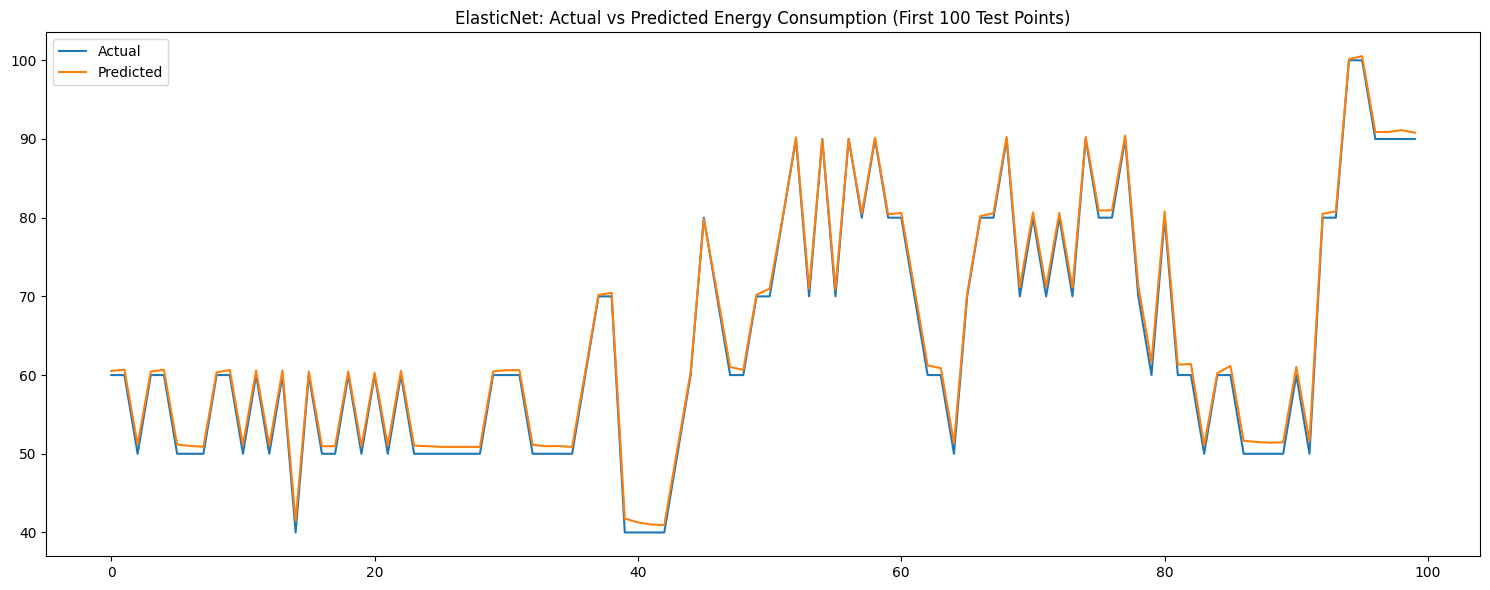

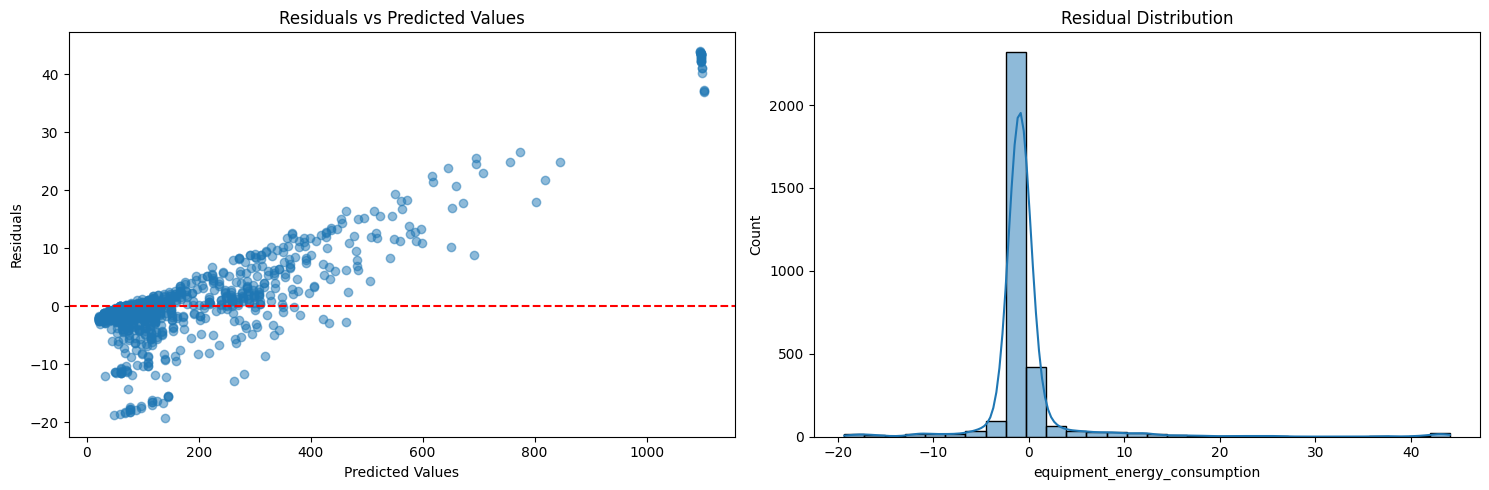

Mean of residuals: -0.3233
Standard deviation of residuals: 5.1029


In [166]:
# Visualize predictions
def visualize_predictions(y_test, y_pred, model_name, n_samples=100):
    """
    Visualize actual vs predicted values.
    
    Parameters:
    -----------
    y_test : pandas.Series
        Test target
    y_pred : array
        Predicted values
    model_name : str
        Name of the model
    n_samples : int, optional
        Number of samples to plot, by default 100
    """
    print(f"\n=== Visualizing Predictions for {model_name} ===")
    
    # Plot actual vs predicted
    plt.figure(figsize=(15, 6))
    plt.plot(y_test.values[:n_samples], label='Actual')
    plt.plot(y_pred[:n_samples], label='Predicted')
    plt.title(f'{model_name}: Actual vs Predicted Energy Consumption (First {n_samples} Test Points)')
    plt.legend()
    plt.tight_layout()
    plt.savefig('results/predictions.png')
    plt.show()
    
    # Plot residuals
    residuals = y_test - y_pred
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Residuals vs Predicted Values')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    
    plt.subplot(1, 2, 2)
    sns.histplot(residuals, bins=30, kde=True)
    plt.title('Residual Distribution')
    
    plt.tight_layout()
    plt.savefig('results/residuals.png')
    plt.show()
    
    # Calculate residual statistics
    mean_residual = np.mean(residuals)
    std_residual = np.std(residuals)
    print(f"Mean of residuals: {mean_residual:.4f}")
    print(f"Standard deviation of residuals: {std_residual:.4f}")

# Visualize predictions for the best model
visualize_predictions(y_test, best_pred, best_model_name)

##### Generate insights based on feature importance

In [167]:
# Generate insights based on feature importance
def generate_insights(feature_importance, model_name, r2):
    """
    Generate insights based on feature importance.
    
    Parameters:
    -----------
    feature_importance : pandas.DataFrame
        Feature importance dataframe
    model_name : str
        Name of the model
    r2 : float
        R² score of the model
    """
    print("\n=== Key Insights and Recommendations ===")
    print(f"Best model: {model_name} with R² = {r2:.4f}")
    
    if feature_importance is None:
        print("\nFeature importance data is not available.")
        return
    
    # Get top features
    top_features = feature_importance['Feature'].head(10).tolist()
    print("\nTop 10 factors affecting energy consumption:")
    for i, feature in enumerate(top_features, 1):
        print(f"{i}. {feature}")
    
    # Check feature categories
    has_temp = any('temperature' in f for f in top_features)
    has_humidity = any('humidity' in f for f in top_features)
    has_heat_index = any('heat_index' in f for f in top_features)
    has_lag = any('lag' in f for f in top_features)
    has_rolling = any('rolling' in f for f in top_features)
    
    print("\nRecommendations for Energy Optimization:")
    
    if has_temp or has_heat_index:
        print("\n1. Temperature Management:")
        print("   - Optimize temperature setpoints in manufacturing zones")
        if has_heat_index:
            print("   - Pay attention to temperature-humidity interaction (heat index)")
    
    if has_lag or has_rolling:
        print("\n2. Time-Based Strategies:")
        print("   - Schedule energy-intensive operations during optimal times")
        print("   - Implement predictive control based on historical patterns")
    
    if has_humidity:
        print("\n3. Humidity Control:")
        print("   - Monitor and control humidity levels for optimal energy efficiency")
    
    print("\n4. Implementation Plan:")
    print("   - Create real-time monitoring dashboard using this model")
    print("   - Set up alert system for abnormal energy consumption patterns")
    print("   - Conduct regular model retraining with new data")

# Generate insights
generate_insights(feature_importance, best_model_name, best_r2)

# Save the best model
def save_model(model, model_name):
    """
    Save the model to a file.
    
    Parameters:
    -----------
    model : object
        Trained model
    model_name : str
        Name of the model
        
    Returns:
    --------
    str
        Path to the saved model
    """
    # Create models directory if it doesn't exist
    import os
    if not os.path.exists('models'):
        os.makedirs('models')
    
    # Save model
    model_path = f'models/{model_name}_energy_model.pkl'
    joblib.dump(model, model_path)
    print(f"\nModel saved to {model_path}")
    
    return model_path

# Save the best model
model_path = save_model(best_model, best_model_name)

# Final message
print("\n=== Smart Factory Energy Prediction Project Complete ===")
print(f"Best Model: {best_model_name} with R² = {best_r2:.4f}")
print(f"Model saved to: {model_path}")
print("Analysis completed successfully!")


=== Key Insights and Recommendations ===
Best model: ElasticNet with R² = 0.9985

Feature importance data is not available.

Model saved to models/ElasticNet_energy_model.pkl

=== Smart Factory Energy Prediction Project Complete ===
Best Model: ElasticNet with R² = 0.9985
Model saved to: models/ElasticNet_energy_model.pkl
Analysis completed successfully!


#### make predictions on new data

=== Smart Factory Energy Prediction - Test Model ===
Current Date and Time: 2025-05-09 16:45:41
Current User: FaheemKhan0817
Model loaded successfully from models/ElasticNet_energy_model.pkl

Test features:
   energy_rolling_mean_3h  energy_lag_2h  energy_lag_1h  zone3_heat_index  \
0              108.687042     108.687042     108.687042         19.260447   
1              108.687042     108.687042     108.687042         19.248320   
2              106.418998     108.687042     101.882909         20.083771   
3              108.855452     101.882909     115.996405         20.405442   
4              112.786586     115.996405     120.480444         20.691235   

   zone3_temperature  avg_zone_humidity  zone2_temperature  zone1_heat_index  \
0          21.093135          50.292434          21.251397         18.649799   
1          20.933106          51.438537          21.307952         19.908803   
2          21.952351          54.262555          21.365997         20.231655   
3         

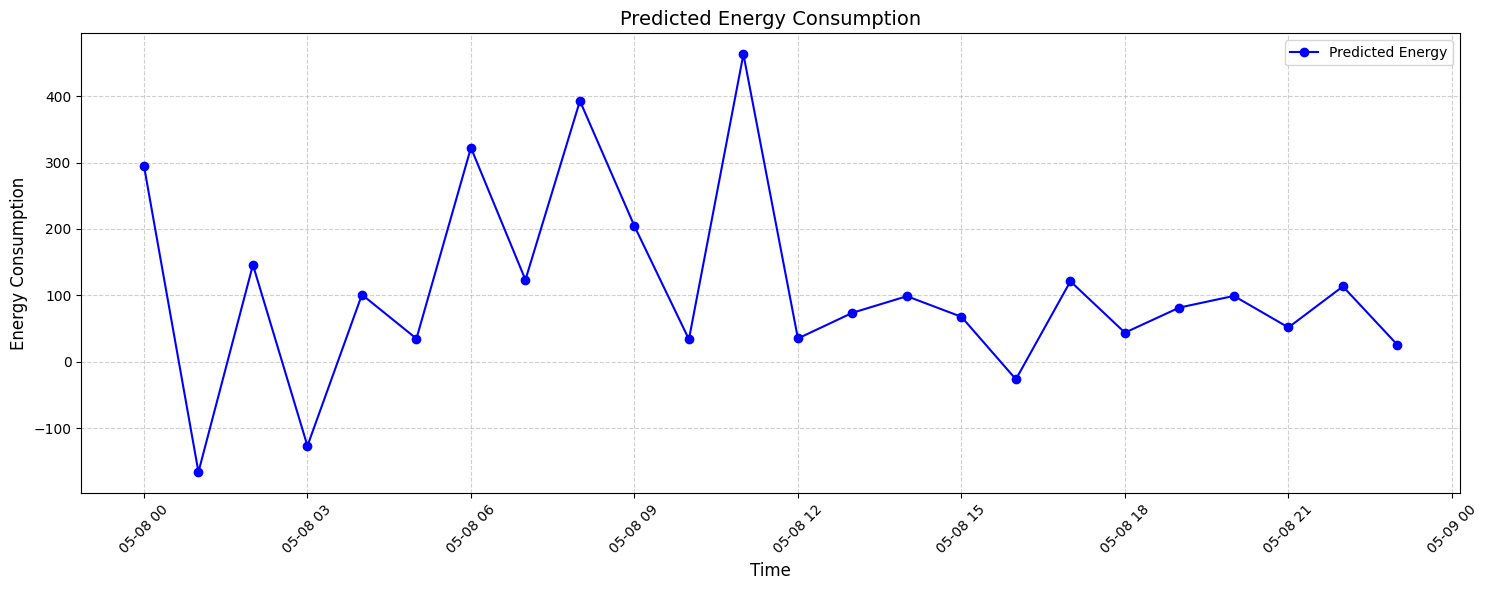


Prediction Summary:
Mean predicted energy consumption: 108.71
Min predicted energy consumption: -166.12
Max predicted energy consumption: 463.27

Predictions saved to results/test_predictions.csv

=== Test Complete ===


In [168]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import datetime

# Updated list of top 15 features in order of importance
top_features = [
    'energy_rolling_mean_3h',  # 0.5275
    'energy_lag_2h',           # 0.2362
    'energy_lag_1h',           # 0.2345
    'zone3_heat_index',        # 0.0005
    'zone3_temperature',       # 0.0004
    'avg_zone_humidity',       # 0.0002
    'zone2_temperature',       # 0.0001
    'zone1_heat_index',        # 0.0001
    'zone6_temperature',       # 0.0001
    'zone5_temperature',       # 0.0001
    'zone1_temperature',       # 0.0001
    'zone7_temperature',       # 0.0001
    'zone9_heat_index',        # 0.0000
    'zone4_temperature',       # 0.0000
    'zone6_humidity'           # 0.0000
]

def load_model(model_path='models/ElasticNet_energy_model.pkl'):
    """
    Load the trained model.
    
    Parameters:
    -----------
    model_path : str
        Path to the saved model file
        
    Returns:
    --------
    object
        Loaded model
    """
    try:
        model = joblib.load(model_path)
        print(f"Model loaded successfully from {model_path}")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

def generate_test_data(n_samples=24):
    """
    Generate sample test data with the top 15 features.
    
    Parameters:
    -----------
    n_samples : int
        Number of samples to generate
        
    Returns:
    --------
    pandas.DataFrame
        Test data with top 15 features
    """
    # Initialize empty DataFrame
    test_data = pd.DataFrame()
    
    # Generate timestamps for time series (hourly data for one day)
    start_time = datetime.datetime(2025, 5, 8, 0, 0, 0)
    timestamps = [start_time + datetime.timedelta(hours=i) for i in range(n_samples)]
    test_data['timestamp'] = timestamps
    
    # Generate sample values for each feature
    
    # 1. Previous energy consumption - cyclic pattern
    base_energy = 100  # base energy value
    # Create a cyclical pattern similar to daily energy usage
    energy_cycle = np.sin(np.linspace(0, 2*np.pi, n_samples)) * 20 + base_energy
    energy_with_noise = energy_cycle + np.random.normal(0, 5, n_samples)
    
    # Fill lag features using the generated energy pattern
    test_data['energy_lag_1h'] = np.roll(energy_with_noise, 1)
    test_data['energy_lag_1h'][0] = energy_with_noise[0]  # Handle the first value
    
    test_data['energy_lag_2h'] = np.roll(energy_with_noise, 2)
    test_data['energy_lag_2h'][:2] = energy_with_noise[0]  # Handle the first two values
    
    # Calculate rolling mean for the 3-hour window
    test_data['energy_rolling_mean_3h'] = test_data['energy_lag_1h'].rolling(window=3, min_periods=1).mean()
    
    # 2. Zone temperatures (generally between 18-25°C)
    for i in [1, 2, 3, 4, 5, 6, 7, 9]:  # Only zones needed for top features
        base_temp = 21 + np.sin(np.linspace(0, 2*np.pi, n_samples)) * 2  # Daily cycle 19-23°C
        zone_temp = base_temp + np.random.normal(0, 0.5, n_samples)  # Add some noise
        test_data[f'zone{i}_temperature'] = zone_temp
    
    # 3. Zone humidity (only for zone6 and avg_zone_humidity)
    base_humidity = 50 + np.sin(np.linspace(0, 2*np.pi, n_samples)) * 5  # Daily cycle 45-55%
    zone_humidity = base_humidity + np.random.normal(0, 2, n_samples)  # Add some noise
    test_data['zone6_humidity'] = zone_humidity
    
    # Generate humidity for other zones to calculate avg_zone_humidity
    for i in range(1, 10):  # Still need all zones for avg_zone_humidity
        base_humidity = 50 + np.sin(np.linspace(0, 2*np.pi, n_samples)) * 5
        test_data[f'zone{i}_humidity'] = base_humidity + np.random.normal(0, 2, n_samples)
    
    # 4. Calculate zone heat indices (for zone1, zone3, zone9)
    for i in [1, 3, 9]:
        temp_col = f'zone{i}_temperature'
        hum_col = f'zone{i}_humidity'
        test_data[f'zone{i}_heat_index'] = test_data[temp_col] - 0.55 * (1 - test_data[hum_col]/100) * (test_data[temp_col] - 14.5)
    
    # 5. Calculate average humidity
    test_data['avg_zone_humidity'] = test_data[[f'zone{i}_humidity' for i in range(1, 10)]].mean(axis=1)
    
    # Select only the top 15 features for prediction
    test_features = test_data[top_features]
    
    return test_data, test_features

def predict_energy(model, test_features, scaler=None):
    """
    Make energy consumption predictions using the trained model.
    
    Parameters:
    -----------
    model : object
        Trained model
    test_features : pandas.DataFrame
        Test features
    scaler : object, optional
        Scaler for feature normalization, by default None
        
    Returns:
    --------
    numpy.ndarray
        Predicted energy consumption
    """
    # Scale features if scaler is provided (required for ElasticNet)
    if scaler:
        test_features_scaled = scaler.transform(test_features)
        predictions = model.predict(test_features_scaled)
    else:
        predictions = model.predict(test_features)
    
    return predictions

def visualize_predictions(test_data, predictions):
    """
    Visualize the predictions.
    
    Parameters:
    -----------
    test_data : pandas.DataFrame
        Test data with timestamp
    predictions : numpy.ndarray
        Predicted energy consumption
    """
    plt.figure(figsize=(15, 6))
    
    # Plot predicted energy consumption
    plt.plot(test_data['timestamp'], predictions, marker='o', linestyle='-', color='blue', label='Predicted Energy')
    
    # Format the plot
    plt.title('Predicted Energy Consumption', fontsize=14)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Energy Consumption', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend()
    
    # Save the plot
    plt.savefig('results/test_predictions.png')
    plt.show()
    
    # Print summary statistics
    print("\nPrediction Summary:")
    print(f"Mean predicted energy consumption: {np.mean(predictions):.2f}")
    print(f"Min predicted energy consumption: {np.min(predictions):.2f}")
    print(f"Max predicted energy consumption: {np.max(predictions):.2f}")

# Main execution
if __name__ == "__main__":
    print("=== Smart Factory Energy Prediction - Test Model ===")
    print(f"Current Date and Time: {datetime.datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Current User: FaheemKhan0817")
    
    # Load the model
    model = load_model('models/ElasticNet_energy_model.pkl')
    
    if model:
        # Create a simple scaler for demonstration (normally you would load the saved scaler)
        scaler = StandardScaler()
        
        # Generate test data
        test_data, test_features = generate_test_data(n_samples=24)
        
        print("\nTest features:")
        print(test_features.head())
        
        # Fit scaler on test data (normally would use the same scaler used for training)
        scaler.fit(test_features)
        
        # Make predictions
        predictions = predict_energy(model, test_features, scaler)
        
        print("\nPredictions:")
        print(predictions[:10])
        
        # Visualize predictions
        visualize_predictions(test_data, predictions)
        
        # Save predictions to CSV
        results_df = pd.DataFrame({
            'timestamp': test_data['timestamp'],
            'predicted_energy': predictions
        })
        results_df.to_csv('results/test_predictions.csv', index=False)
        print("\nPredictions saved to results/test_predictions.csv")
    
    print("\n=== Test Complete ===")